#Run this cell first#

In [ ]:
!pip install opencv-contrib-python
!pip install pytesseract
!apt install tesseract-ocr
!sudo apt-get install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


Main Code - please upload the image, and the OCR model.

Original Image:


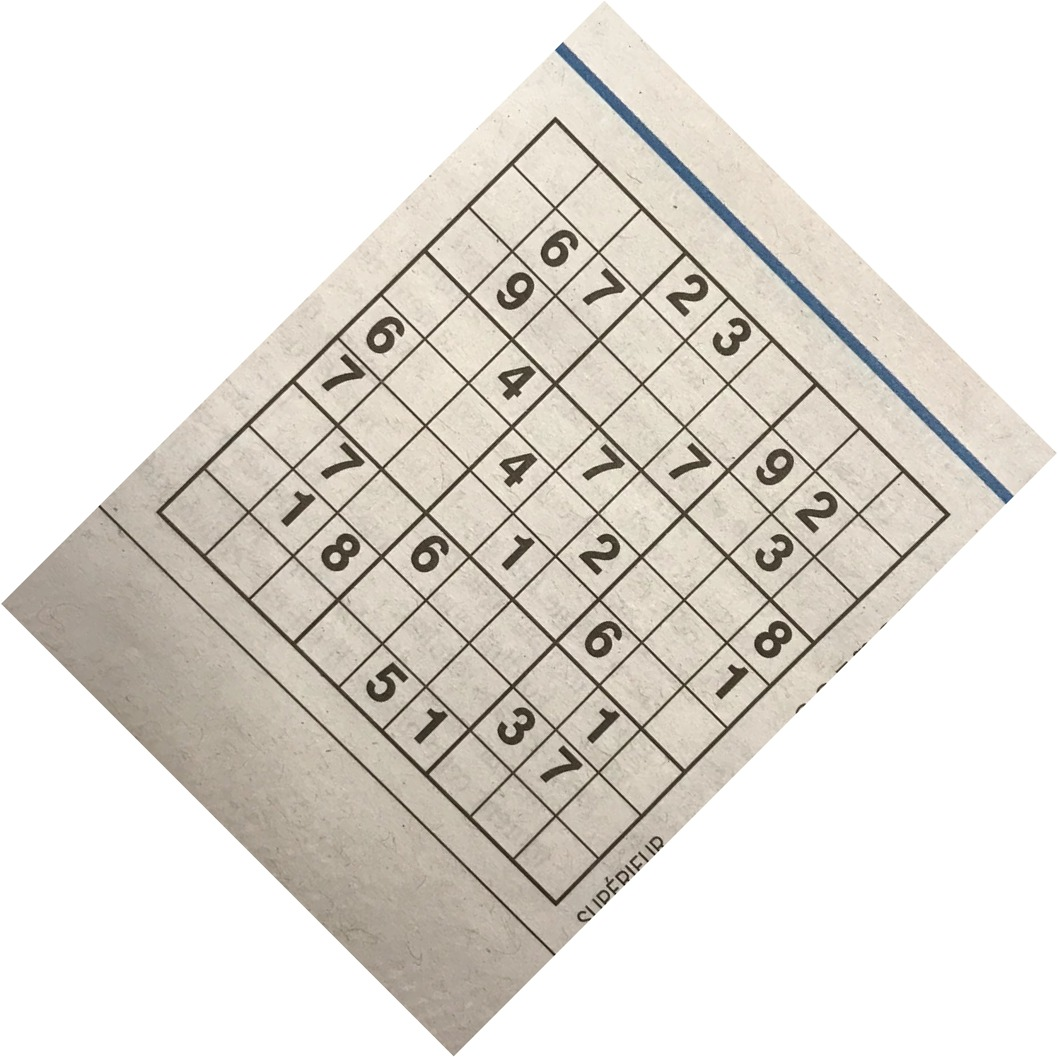

Contours Image:


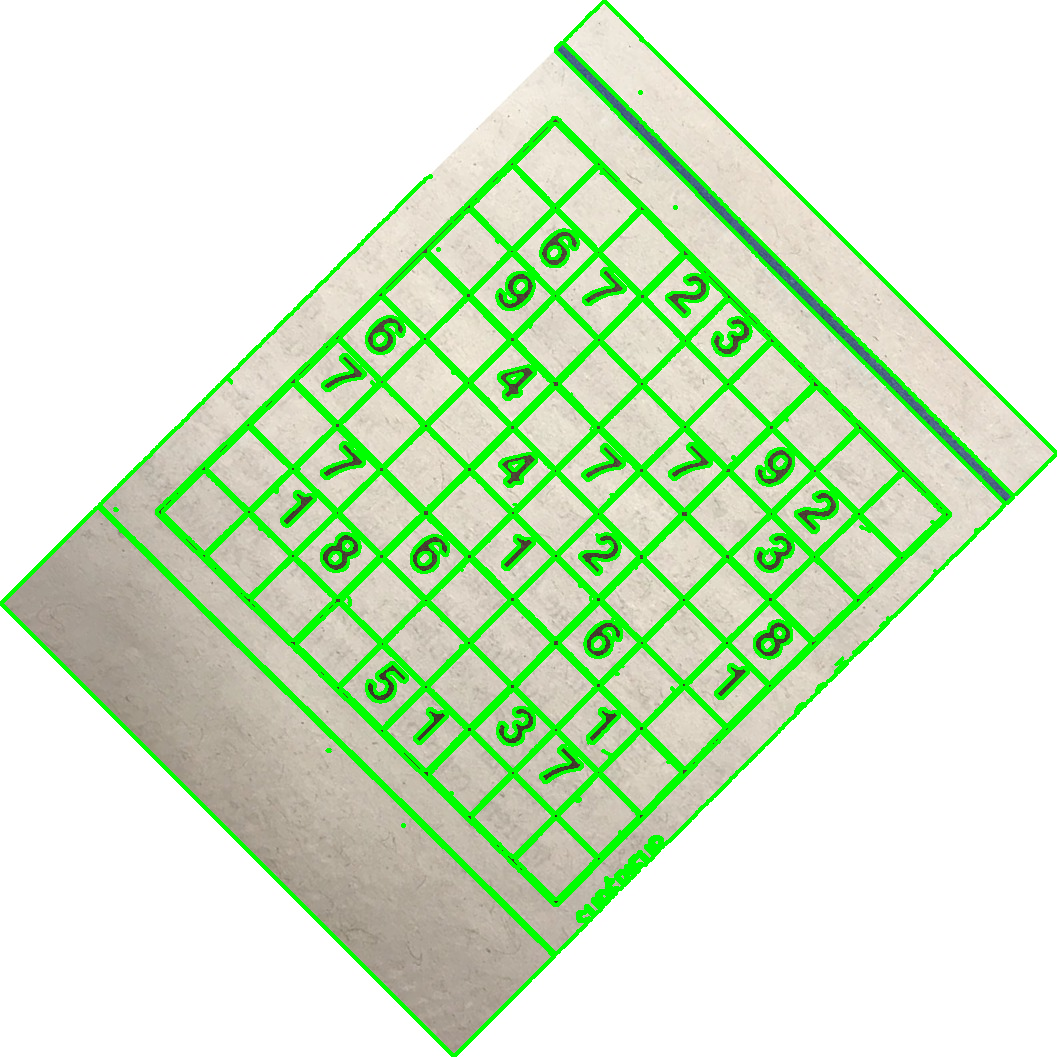

/usr/local/lib/python3.8/dist-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Rotation: 90.00 degrees
270
After Fixing Rotation Image:


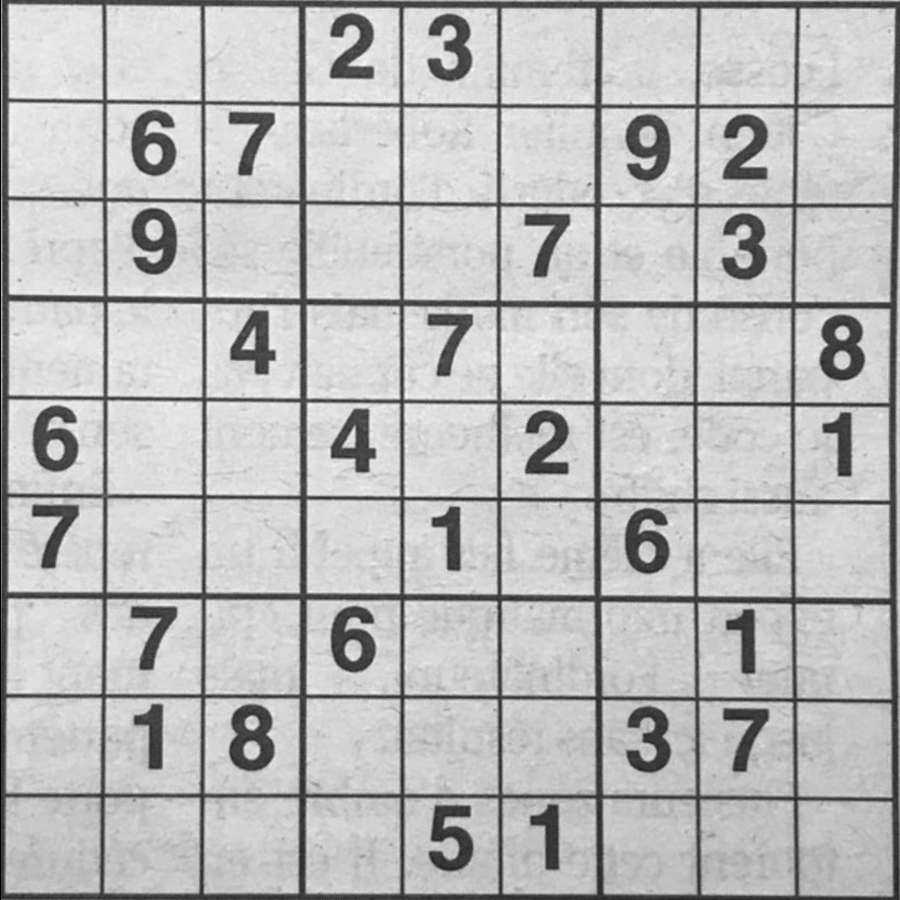

3/3 [==============================] - 1s 153ms/step
[[0 0 0 2 3 0 0 0 0]
 [0 6 7 0 0 0 9 2 0]
 [0 9 0 0 0 7 0 3 0]
 [0 0 4 0 7 0 0 0 8]
 [6 0 0 4 0 2 0 0 1]
 [7 0 0 0 1 0 6 0 0]
 [0 7 0 6 0 0 0 1 0]
 [0 1 8 0 0 0 3 7 0]
 [0 0 0 0 5 1 0 0 0]]


In [ ]:

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import imutils
import tensorflow as tf
from typing import List
from typing import Tuple
from skimage.transform import radon
import pytesseract



def get_perspective(img, location, height = 900, width = 900):
    # Takes an image and location os interested region
    # And return the only the selected region with a perspective transformation
    pts1 = np.float32([location[0], location[3], location[1], location[2]]) # Get 4 vertics
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])   # Set DESIRED formation
    matrix = cv2.getPerspectiveTransform(pts1, pts2)    # Get the transform
    result = cv2.warpPerspective(img, matrix, (width, height))  # Use the transform
    return result


def split_sudoku_board(board: np.ndarray) -> List[np.ndarray]:
    # Splits the sudoku board into a list of 81 individual cells, each containing an element of the board
    rows = np.array_split(board, 9, axis=0)
    cells = []
    for row in rows:
        columns = np.array_split(row, 9, axis=1)
        for cell in columns:
            resized_cell = cv2.resize(cell, (48, 48))
            normalized_cell = resized_cell / 255.0
            cells.append(normalized_cell)
    cv2.destroyAllWindows()
    return cells



def find_board_location(contours: List[np.ndarray]) -> np.ndarray:
    # Find the location of the sudoku board within the contours
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    board_location = None

    # Find the rectangular contour
    for contour in sorted_contours:
        polygon = cv2.approxPolyDP(contour, 15, True)
        if len(polygon) == 4:
            board_location = polygon
            break
    return board_location

def locate_sudoku_board(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Locate the sudoku board within the image and return both the sudoku board and its location in the original image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_image = cv2.bilateralFilter(gray_image, 13, 20, 20)
    edges = cv2.Canny(filtered_image, 30, 180)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    board_location = find_board_location(contours)

    # Ensure the image is in the correct orientation BEFORE proccessing it
    if board_location is None:
        image = imutils.rotate_bound(image, 90)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        filtered_image = cv2.bilateralFilter(gray_image, 13, 20, 20)
        edges = cv2.Canny(filtered_image, 30, 180)
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        board_location = find_board_location(contours)

    print("Contours Image:")
    cv2_imshow(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 2))

    board = get_perspective(image, board_location)
    return board


def find_numbers(cell_arr):
    # Apply OCR model in order to predict the number in each cell / 0 if the cell is missing
  classes = np.arange(0, 10)
  model = tf.keras.models.load_model('model-OCR.h5')
  prediction = model.predict(cell_arr)
  predicted_numbers = []
  # Get classes from prediction
  for i in prediction: 
      index = (np.argmax(i)) # Returns the index of the maximum number of the array
      predicted_number = classes[index]
      predicted_numbers.append(predicted_number)
  return np.array(predicted_numbers).astype('uint8').reshape(9, 9)  # Use reshape to reformat the 81 cells in a sudoku format

def try_rotating(binary_board):
  h, w = binary_board.shape
  # If the resolution is high, resize the image to reduce processing time.
  if (w > 640):
      I = cv2.resize(binary_board, (640, int((h / w) * 640)))
  I = I - np.mean(I)  # Demean; make the brightness extend above and below zero
  # Do the radon transform
  sinogram = radon(I)
  # Find the RMS value of each row and find "busiest" rotation,
  # where the transform is lined up perfectly with the alternating dark
  # text and white lines
  r = np.array([np.sqrt(np.mean(np.abs(line) ** 2)) for line in sinogram.transpose()])
  rotation = np.argmax(r)
  print('Rotation: {:.2f} degrees'.format(90 - rotation))

  # Rotate and save with the original resolution
  M = cv2.getRotationMatrix2D((w/2,h/2),90 - rotation,1)
  dst = cv2.warpAffine(binary_board,M,(w,h))
  # Finally, if the image is rotated at exactly 90/180/270 degrees, tilt it back using pytesseract
  res = pytesseract.image_to_osd(dst)
  # Extract the orientation information
  for r in res.splitlines():
      if "Orientation in degrees:" in r:
          orientation = int(r.split(":")[1].strip())
  print(orientation)
  # Rotate the image based on the orientation information
  (h, w) = dst.shape[:2]
  center = (w // 2, h // 2)     # Find the center, so we could rotate around it
  M = cv2.getRotationMatrix2D(center, orientation, 1.0)
  dst = cv2.warpAffine(dst, M, (w, h))
  print("After Fixing Rotation Image:")
  cv2_imshow(dst)
  return dst


#########################  Set the input image.   #########################
img = cv2.imread('sudoku-rotated 45deg.jpg')
#########################                         #########################

print("Original Image:")
cv2_imshow(img)
board_img = locate_sudoku_board(img)
binary_board = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)


try:  # Try the image as is
  dst = try_rotating(binary_board)
except:   # Else, the image is mirrored, get x-axis-flip
  flipVertical = cv2.flip(binary_board, 0)
  try:  # Try the mirrored image
    dst = try_rotating(flipVertical)
  except:   # The image could not be processed
    print("bad image")

cells = split_sudoku_board(dst) # Split the image to 9x9 = 81 cells
cell_arr = np.array(cells)
cell_arr = cell_arr.reshape(-1, 48, 48, 1)
numbers = find_numbers(cell_arr)    # Use the OCR model to predict the numbers in each cell
print(numbers)

#Solving the Sudoku!#

We would like to give credit to the authors of this sudoku solver:


https://github.com/Lakshmi-1212/Sudoku_Solver_LP/blob/main/Solver_LP.ipynb 

In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 49.5 MB/s eta 0:00:00


In [ ]:
import pulp as plp


def add_default_sudoku_constraints(prob, grid_vars, rows, cols, grids, values):
    
    # Constraint to ensure only one value is filled for a cell
    for row in rows:
        for col in cols:
                prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value] for value in values]),
                                        sense=plp.LpConstraintEQ, rhs=1, name=f"constraint_sum_{row}_{col}"))


    # Constraint to ensure that values from 1 to 9 is filled only once in a row        
    for row in rows:
        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for col in cols]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_row_{row}_{value}"))

    # Constraint to ensure that values from 1 to 9 is filled only once in a column        
    for col in cols:
        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for row in rows]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_col_{col}_{value}"))


    # Constraint to ensure that values from 1 to 9 is filled only once in the 3x3 grid       
    for grid in grids:
        grid_row  = int(grid/3)
        grid_col  = int(grid%3)

        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[grid_row*3+row][grid_col*3+col][value]*value  for col in range(0,3) for row in range(0,3)]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_grid_{grid}_{value}"))
            
def add_prefilled_constraints(prob, input_sudoku, grid_vars, rows, cols, values):
    for row in rows:
        for col in cols:
            if(input_sudoku[row][col] != 0):
                prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for value in values]), 
                                                    sense=plp.LpConstraintEQ, 
                                                    rhs=input_sudoku[row][col],
                                                    name=f"constraint_prefilled_{row}_{col}"))
                
def extract_solution(grid_vars, rows, cols, values):
    solution = [[0 for col in cols] for row in rows]
    grid_list = []
    for row in rows:
        for col in cols:
            for value in values:
                if plp.value(grid_vars[row][col][value]):
                    solution[row][col] = value 
    return solution


def print_solution(solution, rows,cols):
    # Print the final result
    print(f"\nFinal result:")

    print("\n\n+ ----------- + ----------- + ----------- +",end="")
    for row in rows:
        print("\n",end="\n|  ")
        for col in cols:
            num_end = "  |  " if ((col+1)%3 == 0) else "   "
            print(solution[row][col],end=num_end)

        if ((row+1)%3 == 0):
            print("\n\n+ ----------- + ----------- + ----------- +",end="")



def solve_sudoku(input_sudoku, diagonal = False ):
    # Create the linear programming problem
    prob = plp.LpProblem("Sudoku_Solver")

    rows = range(0,9)
    cols = range(0,9)
    grids = range(0,9)
    values = range(1,10)

    # Decision Variable/Target variable
    grid_vars = plp.LpVariable.dicts("grid_value", (rows,cols,values), cat='Binary') 

    # Set the objective function
    # Sudoku works only on the constraints - feasibility problem 
    # There is no objective function that we are trying maximize or minimize.
    # Set a dummy objective
    objective = plp.lpSum(0)
    prob.setObjective(objective)

    # Create the default constraints to solve sudoku
    add_default_sudoku_constraints(prob, grid_vars, rows, cols, grids, values)
        
    # Fill the prefilled values from input sudoku as constraints
    add_prefilled_constraints(prob, input_sudoku, grid_vars, rows, cols, values)


    # Solve the problem
    prob.solve()

    # Print the status of the solution
    solution_status = plp.LpStatus[prob.status]
    print(f'Solution Status = {plp.LpStatus[prob.status]}')

    # Extract the solution if an optimal solution has been identified
    if solution_status == 'Optimal':
        solution = extract_solution(grid_vars, rows, cols, values)
        print_solution(solution, rows,cols)



solve_sudoku(input_sudoku=numbers, diagonal=False)      # Use previous detected data in order to solve the sudoku

Solution Status = Optimal

Final result:


+ ----------- + ----------- + ----------- +

|  8   4   5  |  2   3   9  |  1   6   7  |  

|  3   6   7  |  1   4   8  |  9   2   5  |  

|  2   9   1  |  5   6   7  |  8   3   4  |  

+ ----------- + ----------- + ----------- +

|  1   5   4  |  3   7   6  |  2   9   8  |  

|  6   8   3  |  4   9   2  |  7   5   1  |  

|  7   2   9  |  8   1   5  |  6   4   3  |  

+ ----------- + ----------- + ----------- +

|  4   7   2  |  6   8   3  |  5   1   9  |  

|  5   1   8  |  9   2   4  |  3   7   6  |  

|  9   3   6  |  7   5   1  |  4   8   2  |  

+ ----------- + ----------- + ----------- +